In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import linalg
from tqdm import tqdm
import numpy
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import datasets

# load dataset into Pandas DataFrame
bc = datasets.load_breast_cancer()
df = pd.DataFrame(data=bc.data)


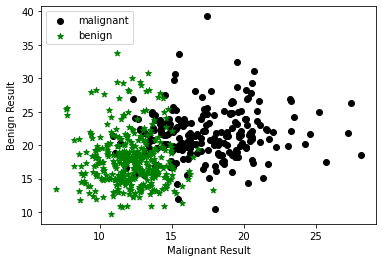

In [2]:
df["label"] = bc.target
plt.scatter(df[0][df["label"] == 0], df[1][df["label"] == 0], color='black', marker='o', label='malignant')
plt.scatter(df[0][df["label"] == 1], df[1][df["label"] == 1],  color='green', marker='*', label='benign')
plt.xlabel('Malignant Result')
plt.ylabel('Benign Result')
plt.legend(loc='upper left')
plt.show()

In [3]:
print(bc['target_names'])
print(bc.keys())
df=pd.DataFrame(bc['data'], columns=bc['feature_names'])

['malignant' 'benign']
dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename'])


In [4]:
from sklearn.preprocessing import MinMaxScaler
#for min max scaler
scaler=MinMaxScaler()
scaler.fit(df)
X= scaler.transform(df)
x= scaler.transform(df)


In [5]:
array = df.values
X = array[:,1:]
Y = array[:,0]



Text(0, 0.5, 'Second Principal Component')

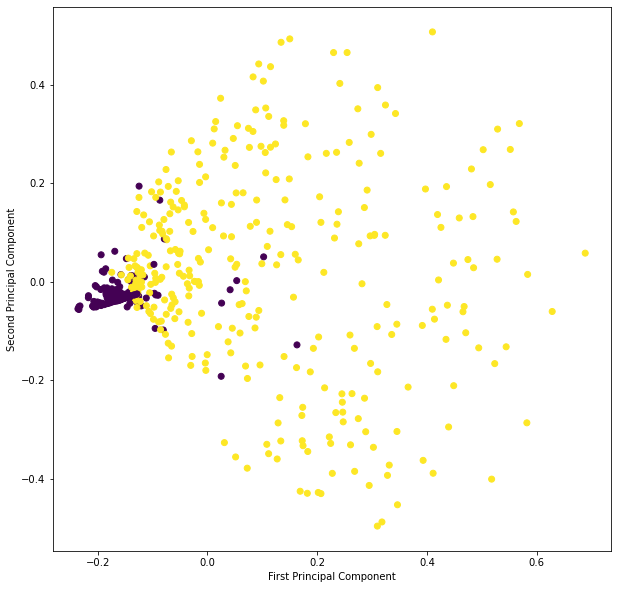

In [6]:
from sklearn.decomposition import KernelPCA
kpca = KernelPCA(n_components=2, kernel='rbf', gamma=10)
x_kpca = kpca.fit_transform(X)
principalComponents = kpca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents, columns = ['PC-1', 'PC-2'])



#plotting based on target values
plt.figure(figsize=(10,10))
plt.scatter(principalComponents[:,0],principalComponents[:,1],c=bc['target'])
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')

In [7]:
class KPCA:
    def __init__(self, kernel):
        self.kernel = kernel
        self.X = None
        self.A = None
        self.MV= None
        
    def getNormalise(self, data):
        len= data.shape[0]
        data_1 = numpy.ones((len, len)) / len
        GramMatrix= self.kernel.GramMatrix(data)
        self.MV = numpy.mean(GramMatrix, axis=1) - numpy.mean(GramMatrix)
        return numpy.dot(numpy.dot(numpy.eye(len) - data_1, GramMatrix), numpy.eye(len) - data_1)
    
    def fit(self, data):
        print("Finding !!! ")
        length = data.shape[0]
        self.X = data
        GM = self.getNormalise(data)       
        eig_values, eig_vectors = linalg.eigh(GM)       
        i = range(length)[::-1]
        eig_values = eig_values[i]
        eig_vectors = eig_vectors[:, i]        
        i = eig_values > 0
        eig_values = eig_values[i]
        eig_vectors = eig_vectors[:, i]
        self.A = eig_vectors
        for a, b in enumerate(eig_values):
            self.A[:, a] /= numpy.sqrt(b)
            
    def predict(self, X, cluster=None):
        assert cluster is None or (cluster > 0 and cluster <= self.A.shape[1])
        if cluster is None:
            cluster = self.A.shape[1]

        GM = self.kernel.GramMatrix(X, self.X)
        K = GM - numpy.mean(GM, axis=1)[:, numpy.newaxis] - self.MV
        return numpy.dot(GM, self.A[:, :cluster])
            
        

In [8]:
class Kernel:
    def __init__(self):
        self.name = None

    def calc(self, x, y):
        raise NotImplementedError("Not Done")

    def GramMatrix(self, X, Y=None):
        if Y is None:
            Y = X
        n = X.shape[0]
        m = Y.shape[0]
        K = numpy.zeros((n, m))

        for i in tqdm(range(n)):
            for j in range(m):
                K[i, j] = self.calc(X[i, :], Y[j, :])
        return K

In [9]:
class PolynomialKernel():
    def __init__(self, degree):
        self.degree = degree
        self.name = 'polynomial_%d' % degree
        
    def calc(self, x, y):
        return (1 + numpy.dot(x, y)) ** self.degree
    
    def GramMatrix(self, X, Y=None):
        if Y is None:
            Y = X
        return numpy.dot(X, Y.T) **self.degree

class LinearKernel():
    def __init__(self):
        self.name = 'linear'

    def calc(self, x, y):
        return numpy.dot(x, y)

    def GramMatrix(self, X, Y=None):
        if Y is None:
            Y = X
        return numpy.dot(X, Y.T)

In [10]:
class GaussianKernel():
    def __init__(self, sigma):
        self.sigma = sigma
        self.name = 'gaussian_%.2f' % sigma

    def calc(self, x, y):
            val=numpy.exp(-numpy.linalg.norm(x - y) ** 2 / (2 * self.sigma ** 2))
            print("Value is"+val)
            return val

    def GramMatrix(self, X, Y=None):
        if Y is None:
            Y = X
        n = X.shape[0]
        m = Y.shape[0]
        K = numpy.zeros((n, m))

        for i in tqdm(range(m)):
            K[:, i] = numpy.linalg.norm(X - Y[i, :], axis=1) ** 2
        K /= 2 * self.sigma ** 2
        return numpy.exp(-K)

In [11]:
class LaplacianKernel():
    def __init__(self, sigma):
        self.sigma = sigma
        self.name = 'gaussian_%.2f' % sigma

    def calc(self, x, y):
            val=numpy.exp(-numpy.linalg.norm(x - y) *self.sigma)
            print("Value is"+val)
            return val

    def GramMatrix(self, X, Y=None):
        if Y is None:
            Y = X
        n = X.shape[0]
        m = Y.shape[0]
        K = numpy.zeros((n, m))

        for i in tqdm(range(m)):
            K[:, i] = numpy.linalg.norm(X - Y[i, :], axis=1)* self.sigma
       
        return numpy.exp(-K)

In [12]:
#First we will test from Standard PCA 
from sklearn.decomposition import PCA
scikit_pca = PCA(n_components=5)
X_spca = scikit_pca.fit_transform(X)
Components = scikit_pca.fit_transform(X)



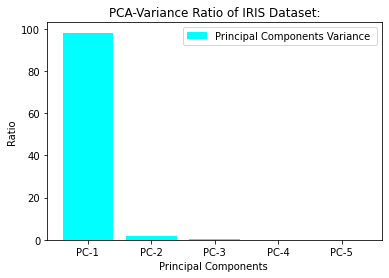

In [14]:
totV = np.var(Components, axis=0)
value_eigen = totV / np.sum(totV)
plt.bar([1,2,3,4,5],list(value_eigen*100),label='Principal Components Variance ',color='cyan')
plt.legend()
plt.xlabel('Principal Components ')
#----------------------
length=list(value_eigen*100)
prinComp=[]
for i in range(len(length)):
    length[i]=round(length[i],4)
    prinComp.append('PC-'+str(i+1))

#----------------------
plt.xticks([1,2,3,4,5],prinComp, fontsize=10)
plt.ylabel('Ratio')
plt.title('PCA-Variance Ratio of IRIS Dataset:')
plt.show()

In [15]:
scikit_pca = PCA(n_components=2)
X_spca = scikit_pca.fit_transform(X)
Components = scikit_pca.fit_transform(X)
axes = pd.DataFrame(data = Components
                 , columns = ['PC-1', 'PC-2'])

print(X_spca.shape)

(569, 2)


Text(0, 0.5, 'Second Principal Component')

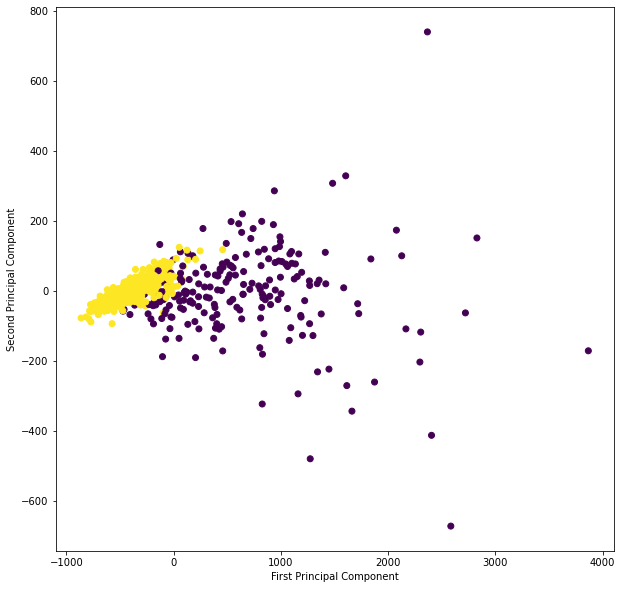

In [28]:
#plotting based on target values
plt.figure(figsize=(10,10))
plt.scatter(Components[:,0],Components[:,1],c=bc['target'])
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')

In [16]:
#Applying Kernel PCA 
#Guassian Kernel :
#umber of components =2 and Gamma=100
kpca = KPCA(GaussianKernel(800))
X_kpca=kpca.fit(X)
X_kpca1 = kpca.predict(X,1)
Components_kpca = kpca.predict(X,2)
axes = pd.DataFrame(data = Components_kpca
                 , columns = ['PC-1', 'PC-2'])
print(X_kpca1.shape)


  0%|                                                                                          | 0/569 [00:00<?, ?it/s]

Finding !!! 


100%|█████████████████████████████████████████████████████████████████████████████| 569/569 [00:00<00:00, 11156.21it/s]

(569, 1)


Text(0, 0.5, 'Second Principal Component')

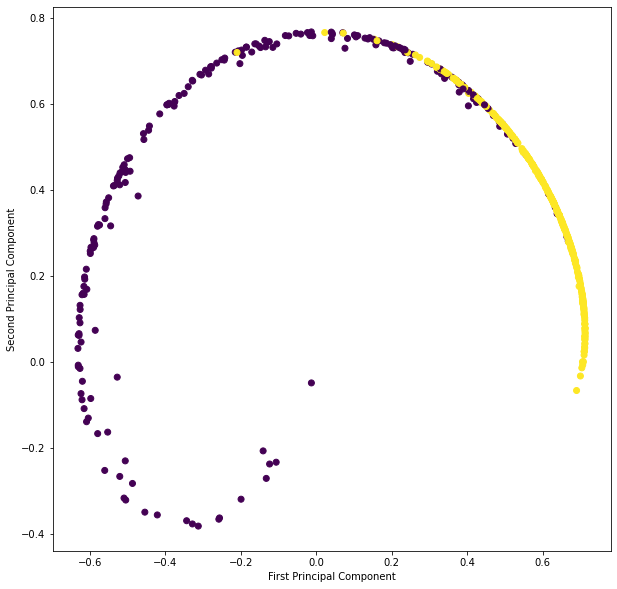

In [17]:
#plotting based on target values
plt.figure(figsize=(10,10))
plt.scatter(Components_kpca[:,0],Components_kpca[:,1],c=bc['target'])
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')